In [34]:
!pip install -q keras
!pip install -q pandas
!pip install -q numpy
!pip install -q hyperopt
!pip install -q hyperas
!pip install -q keras_preprocessing

In [35]:
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input
import numpy as np
import pandas as pd

In [36]:
import pandas as pd
import json
import numpy as np

In [37]:
#from google.colab import drive
#drive.mount('/content/drive')

In [38]:
#with open('/drive/MyDrive/data.00.json') as user_file:
#  parsed_json = user_file.read()

In [39]:
# Download the IPFIX data from this repository. It might take some time depending on network bandwidth

!git clone https://github.com/shrey265/test_data

fatal: destination path 'test_data' already exists and is not an empty directory.


In [40]:
with open('/content/test_data/data.00.json') as user_file:
  parsed_json = user_file.read()

In [41]:
parsed_json = parsed_json.replace('}\n{', '},{')

In [42]:
parsed_json = '['+parsed_json+']'

In [43]:
df = pd.DataFrame(json.loads(parsed_json))

In [44]:
del parsed_json

In [45]:
df

,app_name,exercise_segment,facility,fromhost_ip,hostname,message,procid,programname,severity,timegenerated,timereported,timestamp
0,gendpoint,global,3,10.7.100.7,global-app,"time=""2019-03-19T11:00:00+01:00"" level=info m...",25433.0,gendpoint,6,2019-03-19T11:00:00.000731+01:00,2019-03-19T11:00:00+01:00,1552989600000
1,gendpoint,global,3,10.7.100.7,global-app,[GIN] 2019/03/19 - 11:00:00 | 200 #033[0m| ...,25433.0,gendpoint,6,2019-03-19T11:00:00.000988+01:00,2019-03-19T11:00:00+01:00,1552989600000
2,named,global,3,10.7.100.3,ns,client 4.122.55.5#58236 (12.66.66.9.in-addr.a...,4630.0,named,6,2019-03-19T11:00:00.015144+01:00,2019-03-19T11:00:00+01:00,1552989600015
3,gendpoint,global,3,10.7.100.7,global-app,"time=""2019-03-19T11:00:00+01:00"" level=info m...",25400.0,gendpoint,6,2019-03-19T11:00:00.034285+01:00,2019-03-19T11:00:00+01:00,1552989600034
4,gendpoint,global,3,10.7.100.7,global-app,[GIN] 2019/03/19 - 11:00:00 | 200 #033[0m| ...,25400.0,gendpoint,6,2019-03-19T11:00:00.034570+01:00,2019-03-19T11:00:00+01:00,1552989600034
...,...,...,...,...,...,...,...,...,...,...,...,...
1058445,gendpoint,global,3,10.7.100.7,global-app,[GIN] 2019/03/19 - 14:03:59 | 200 #033[0m| ...,25534.0,gendpoint,6,2019-03-19T14:03:59.322534+01:00,2019-03-19T14:03:59+01:00,1553000639322
1058446,gendpoint,global,3,10.7.100.7,global-app,"time=""2019-03-19T14:03:59+01:00"" level=info m...",25498.0,gendpoint,6,2019-03-19T14:03:59.330384+01:00,2019-03-19T14:03:59+01:00,1553000639330
1058447,gendpoint,global,3,10.7.100.7,global-app,[GIN] 2019/03/19 - 14:03:59 | 200 #033[0m| ...,25498.0,gendpoint,6,2019-03-19T14:03:59.330629+01:00,2019-03-19T14:03:59+01:00,1553000639330
1058448,gendpoint,global,3,10.7.100.7,global-app,"time=""2019-03-19T14:03:59+01:00"" level=info m...",25703.0,gendpoint,6,2019-03-19T14:03:59.336322+01:00,2019-03-19T14:03:59+01:00,1553000639336


In [46]:
samples = []
for row in df.iterrows():
    index, data = row
    samples.append(data.tolist())

In [47]:
len(samples[0])

12

In [48]:
max_words = 200000
maxlen = 12

Input data contains log messages and strings, we need to tokenize the dataset so that we can feed it to autoencoder

In [49]:
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 2718387 unique tokens.


In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
#not sure if min max scaling should be used or not
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

In [52]:
#create training & validation samples

training_samples = int(len(samples) * 0.80)

x = data[:training_samples]
x_validation = data[training_samples:]

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='log_model-testing.h5',
    monitor='val_loss',
    save_best_only=True
    )
]


In [53]:
# Architecture

input_dim = x.shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(8, activation='relu')(input)
encode = Dense(4, activation='relu')(encode)

decode = Dense(8, activation='relu')(encode)
decode = Dense(12, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 8)                 40        
                                                                 
 dense_7 (Dense)             (None, 12)                108       
                                                                 
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = autoencoder.fit(x, x,
        epochs=5,
        batch_size=32,
        callbacks=callbacks_list,
        validation_data=(x_validation, x_validation),
        shuffle=True
        )

Epoch 1/5
26462/26462 [==============================] - 69s 3ms/step - loss: 0.0021 - accuracy: 0.9048 - val_loss: 4.3402e-05 - val_accuracy: 0.9503
Epoch 2/5
26462/26462 [==============================] - 68s 3ms/step - loss: 1.8072e-04 - accuracy: 0.9316 - val_loss: 4.2976e-05 - val_accuracy: 0.9659
Epoch 3/5
26462/26462 [==============================] - 66s 2ms/step - loss: 1.7206e-04 - accuracy: 0.9337 - val_loss: 4.2092e-05 - val_accuracy: 0.9516
Epoch 4/5
26462/26462 [==============================] - 65s 2ms/step - loss: 1.6219e-04 - accuracy: 0.9352 - val_loss: 4.0152e-05 - val_accuracy: 0.9602
Epoch 5/5
26462/26462 [==============================] - 64s 2ms/step - loss: 1.5984e-04 - accuracy: 0.9347 - val_loss: 3.9596e-05 - val_accuracy: 0.9658


In [55]:
import pandas as pd
from numpy import vstack

# Combined x and x_test.

predictions = autoencoder.predict(data)

# Calculated MSE.
mse = np.mean(np.power(data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quantile.
threshold = error_df.quantile(0.999)

error_df.describe()

33077/33077 [==============================] - 55s 2ms/step


,reconstruction_error
count,1.058450e+06
mean,1.342475e-04
std,1.973794e-03
min,1.095304e-08
25%,1.077277e-06
50%,4.630391e-06
75%,2.240574e-05
max,1.464289e-01


In [56]:

%matplotlib inline
import matplotlib.pyplot as plt

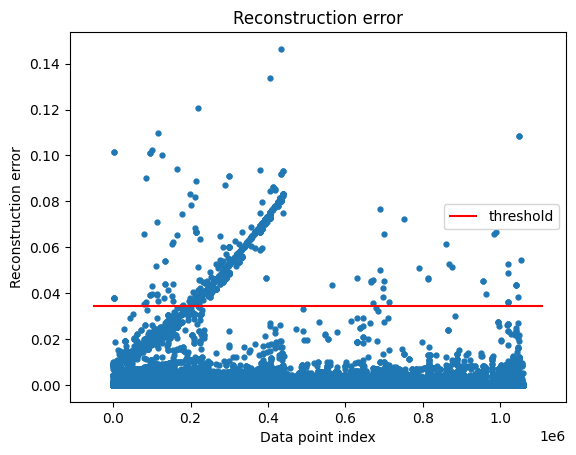

In [57]:
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [58]:
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > np.float(threshold):
        index_list.append(index)


<ipython-input-58-b5e7fc7ebd3c>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if row.reconstruction_error > np.float(threshold):


In [59]:
anomaly = []
for index_val in index_list:
  anomaly.append(df.iloc[index_val])

filtered data from autoencoder

In [60]:
anomaly

[app_name                                        vpnc
 exercise_segment                              global
 facility                                           3
 fromhost_ip                             10.7.100.112
 hostname                                        kali
 message              select: Interrupted system call
 procid                                       21871.0
 programname                                     vpnc
 severity                                           3
 timegenerated       2019-03-19T11:00:36.739745+01:00
 timereported               2019-03-19T11:00:36+01:00
 timestamp                              1552989636739
 Name: 2468, dtype: object,
 app_name                                        vpnc
 exercise_segment                              global
 facility                                           3
 fromhost_ip                             10.7.100.112
 hostname                                        kali
 message                     terminated by signal: 15
